In [1]:
#库的引入
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import transforms
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torch.autograd import Variable

In [3]:
# 定义OOD数据集类
class OodDataset(Dataset):
    def __init__(self, ood_data, transform=None):
        self.ood_data = ood_data
        self.transform = transform

    def __len__(self):
        return len(self.ood_data)

    def __getitem__(self, idx):
        image, _ = self.ood_data[idx]
        if self.transform:
            image = self.transform(image)
        return image, 10  # OOD类的标签为10

In [4]:
#分类器的模型
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 11)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        #h = self.bc1(h)
        h = F.relu(h)
        #h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        #h = self.bc2(h)
        h = F.relu(h)
        #h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.softmax(h,1)
        return out


In [5]:
#transform函数，主要用于把图片转变为tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # 彩色图像转灰度图像num_output_channels默认1
    transforms.RandomCrop((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [6]:
#下载并加载MNIST数据集
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

# 加载CIFAR10数据集作为OOD数据集
cifar10_trainset_1 = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_trainset=OodDataset(cifar10_trainset_1)
cifar10_testset_1 = CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_testset=OodDataset(cifar10_testset_1)
ood_testloader = DataLoader(cifar10_testset, batch_size=64, shuffle=False)

#将MNIST数据集和CIFAR10数据集合并为训练集
trainset=torch.utils.data.ConcatDataset([mnist_trainset,cifar10_trainset])
trainloader=DataLoader(trainset,batch_size=64,shuffle=True)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


102.8%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


112.7%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...


D:\anaconda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
#定义优化器
model = Classifier()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
#模型的训练
model.train()
losses=[]
num_epochs = 3
for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(trainloader):
        images = Variable(images)
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        #loss = criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()
        
        loss = F.cross_entropy(outputs, labels)
        losses.append(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # 训练进度的监测和错误率展示
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(images), 
                len(trainloader.dataset),
                100. * batch_idx / len(trainloader), 
                loss), 
                end='')
            
    print()

 Train Epoch: 0 [108864/110000 (99%)]	Loss: 1.548694
 Train Epoch: 1 [108864/110000 (99%)]	Loss: 1.588872
 Train Epoch: 2 [108864/110000 (99%)]	Loss: 1.577991


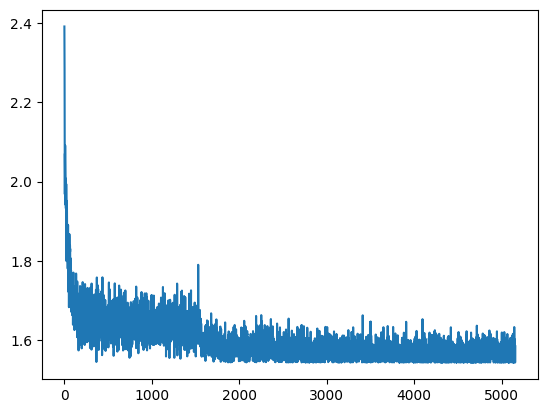

In [9]:
#生成训练过程中losses的变化图
losses = [it.detach().numpy() for it in losses]
plt.plot(losses)

In [10]:

#测试minist数据集
model.eval()
num_epochs = 10  # Number of epochs to run
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for images, labels in mnist_testloader:
        images = Variable(images)
        labels = Variable(labels)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)     

        
        correct += (predicted == labels).sum()

    accuracy = 100 * correct / total
    print('Epoch [{}/{}], Accuracy on Mnist Test Set: {:.2f}%'.format(epoch+1, num_epochs, accuracy))
    


Epoch [1/10], Accuracy on Mnist Test Set: 95.91%
Epoch [2/10], Accuracy on Mnist Test Set: 95.91%
Epoch [3/10], Accuracy on Mnist Test Set: 95.91%
Epoch [4/10], Accuracy on Mnist Test Set: 95.91%
Epoch [5/10], Accuracy on Mnist Test Set: 95.91%
Epoch [6/10], Accuracy on Mnist Test Set: 95.91%
Epoch [7/10], Accuracy on Mnist Test Set: 95.91%
Epoch [8/10], Accuracy on Mnist Test Set: 95.91%
Epoch [9/10], Accuracy on Mnist Test Set: 95.91%
Epoch [10/10], Accuracy on Mnist Test Set: 95.91%


In [11]:
#测试cifar数据集
model.eval()
num_epochs = 10  # Number of epochs to run
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for images, labels in ood_testloader:

        images = Variable(images)
        labels = Variable(labels)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)     
        
        correct += (predicted == labels).sum()
        
 

    accuracy = 100 * correct / total
    print('Epoch [{}/{}], Accuracy on OOD Test Set: {:.2f}%'.format(epoch+1, num_epochs, accuracy))


Epoch [1/10], Accuracy on OOD Test Set: 99.91%
Epoch [2/10], Accuracy on OOD Test Set: 99.89%
Epoch [3/10], Accuracy on OOD Test Set: 99.92%
Epoch [4/10], Accuracy on OOD Test Set: 99.87%
Epoch [5/10], Accuracy on OOD Test Set: 99.92%
Epoch [6/10], Accuracy on OOD Test Set: 99.89%
Epoch [7/10], Accuracy on OOD Test Set: 99.89%
Epoch [8/10], Accuracy on OOD Test Set: 99.88%
Epoch [9/10], Accuracy on OOD Test Set: 99.91%
Epoch [10/10], Accuracy on OOD Test Set: 99.89%
